## **Library and Modul**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# import metric
from keras.metrics import categorical_crossentropy
# optimization method 
from keras.optimizers import SGD
import os

## **Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
abnormal = '/content/drive/MyDrive/EKG RSUI/Data_Abnormal'
normal = '/content/drive/MyDrive/EKG RSUI/Data Normal'
data ='/content/drive/MyDrive/EKG RSUI'

## **Pre-Processing**

In [ ]:
train_path = '/content/drive/MyDrive/EKG RSUI' + '/' + 'training_set/' 
test_path = '/content/drive/MyDrive/EKG RSUI' + '/' + 'test_set/'

In [ ]:
print('The training set consists of ', len(os.listdir(train_path + 'normal')), 
      ' normal images and ', len(os.listdir(train_path + 'abnormal')), ' abnormal images.' )

The training set consists of  252  normal images and  252  abnormal images.


In [ ]:
print('The test set consists of ', len(os.listdir(test_path + 'normal')), 
      ' normal images and ', len(os.listdir(test_path + 'abnormal')), ' abnormal images.' )

The test set consists of  36  normal images and  36  abnormal images.


In [ ]:
import cv2
from PIL import Image
import numpy as np

cates = ['normal', 'abnormal']
def load_images_and_labels(data_path, cates): 
  X = []
  y = []
  i = 0
  for index, cate in enumerate(cates): 
    for img_name in os.listdir(data_path + cate + '/'):
      i = i +1
      print(i)
      img = cv2.imread(data_path + cate + '/' + img_name)
      if img is not None: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = Image.fromarray(img, 'RGB')
        # resize image to 227x227 which is the required input size of the Alexnet model
        img_rs = img_array.resize((227,227))
        # convert the image to array
        img_rs = np.array(img_rs)
      
        X.append(img_rs)
        y.append(index)
  return X, y

In [ ]:
X_train, y_train = load_images_and_labels(train_path, cates)
X_test, y_test = load_images_and_labels(test_path, cates)

In [ ]:
data_dict = {'X_train' : X_train, 
             'y_train': y_train, 
             'X_test': X_test, 
             'y_test': y_test}
np.save('data_dict.npy', data_dict)

In [ ]:
data_dict_ = np.load('data_dict.npy', allow_pickle = True).item()
X_train = data_dict_['X_train']
y_train = data_dict_['y_train']
X_test = data_dict_['X_test']
y_test = data_dict_['y_test']

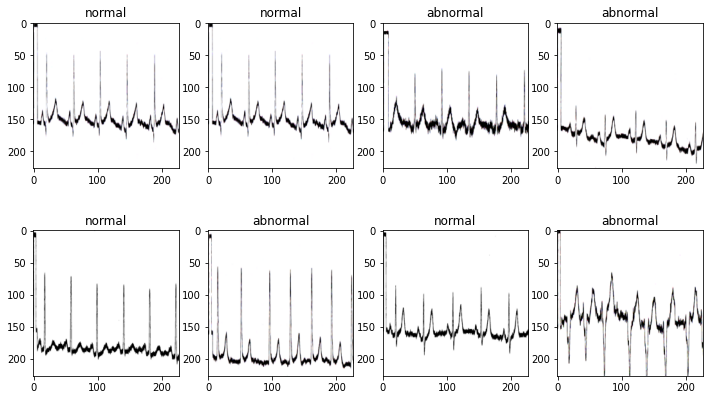

In [ ]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize = (12,7))
cate = ['normal', 'abnormal']
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(cate[y_train[ind]])

In [ ]:
from keras.utils import to_categorical

def preprocess_data(X, y):
  # convert X from list to array
  X = np.array(X)
  
  # convert integer values of X into floats
  X = X.astype(np.float32)

  # normalization 
  X = X/255.0
  
  # one-hot encoding the labels 
  y = to_categorical(np.array(y))
    
  return X, y
  
(X_train, y_train) = preprocess_data(X_train, y_train)
(X_test, y_test) = preprocess_data(X_test, y_test)

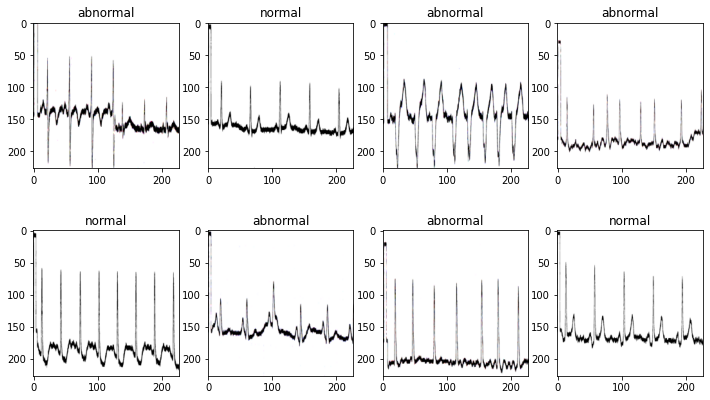

In [ ]:
plt.figure(figsize = (12,7))
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(cate[np.argmax(y_train[ind])])

## **Model Training**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# metric
from keras.metrics import binary_crossentropy
# optimization method (Stochastic Gradient Descent (SGD))
from keras.optimizers import SGD

In [ ]:
def Alexnet():
  # Initialize the model
  model = Sequential()

  # layer 1: convolutional layer + max-pooling layer
  model.add(Conv2D(filters = 96, kernel_size = (11,11), strides= 4, padding = 'valid', 
                   activation='relu', input_shape = (227,227,3)))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layer 2: convolutional layer + max-pooling layer 
  model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', 
                   activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 3-5: three convolutional layers + 1 max-pooling layer
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 6 - 8: two fully connected hidden layers and one fully connected output layer
  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation = 'softmax'))

  # compile the model with a loss funciton, a metric and and optimizqation method
  opt = SGD(learning_rate = 0.1)
  model.compile(loss = binary_crossentropy,
                optimizer = opt,
                metrics = ['accuracy'], run_eagerly=True)

  return model

In [ ]:
Alexnet_model = Alexnet()
Alexnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 384)       885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 384)      

## **Training**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
  # Data generator
  datagen = ImageDataGenerator(rotation_range = 0, width_shift_range = 0.1, 
                               height_shift_range = 0.1, horizontal_flip = False)
  # iteration on the training set
  it_train = datagen.flow(X_train, y_train, batch_size = batch_size)
  # path to save the checkpoint 
  path_cp = os.getcwd() + '/' + 'weights_.hdf5'
  checkpoint_ = ModelCheckpoint(path_cp, monitor = 'loss', save_best_only = False, 
                                mode = 'auto')
  steps = X_train.shape[0]//batch_size
  # Fitting the model
  history = model.fit_generator(it_train, epochs = epochs, steps_per_epoch = steps, 
                                validation_data = (X_test, y_test), verbose = 1, 
                                callbacks = checkpoint_)
  # Evaluating the model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  
  return history, acc

In [ ]:
train_history, acc = train_model(Alexnet_model, X_train, y_train, X_test, y_test, 
                                 epochs = 10, batch_size = 128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
3/3 [==============================] - 4s 2s/step - loss: 0.6621 - accuracy: 0.6144 - val_loss: 0.5796 - val_accuracy: 0.8333
Epoch 2/10
3/3 [==============================] - 4s 2s/step - loss: 0.5882 - accuracy: 0.7686 - val_loss: 0.5494 - val_accuracy: 0.8472
Epoch 3/10
3/3 [==============================] - 4s 1s/step - loss: 0.6122 - accuracy: 0.7261 - val_loss: 0.6435 - val_accuracy: 0.5556
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 0.6004 - accuracy: 0.6915 - val_loss: 0.5308 - val_accuracy: 0.7917
Epoch 5/10
3/3 [==============================] - 4s 1s/step - loss: 0.6143 - accuracy: 0.6995 - val_loss: 0.6759 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 4s 1s/step - loss: 0.6033 - accuracy: 0.6862 - val_loss: 0.5093 - val_accuracy: 0.8472
Epoch 7/10
3/3 [==============================] - 4s 2s/step - loss: 0.5406 - accuracy: 0.8165 - val_loss: 0.4881 - val_accuracy: 0.8194
Epoch 8/10
3/3 [=========================

In [ ]:
import pandas as pd

# convert the history.history to a pandas DataFrame:     
train_hist_df = pd.DataFrame(train_history.history) 

train_dict = {'train_hist': train_hist_df, 
              'acc': acc}
np.save('train_dict.npy', train_dict)  

In [ ]:
Alexnet_model.save('Alexnet_model.h5')

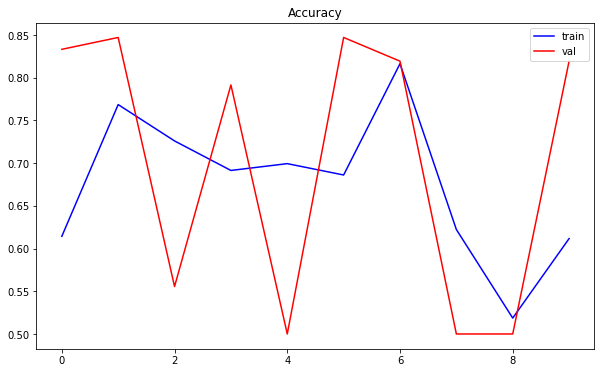

In [ ]:
def plot_accuracy(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()
  
plot_accuracy(train_history)

In [ ]:
y_test_pred = []
for i in np.arange(len(X_test)):
  img = X_test[i]
  img = img.reshape(1, 227, 227, 3)
  y_p = Alexnet_model.predict(img)
  y_test_pred.append(y_p)

y_test_pred = np.asarray(y_test_pred)

Text(69.0, 0.5, 'True classes')

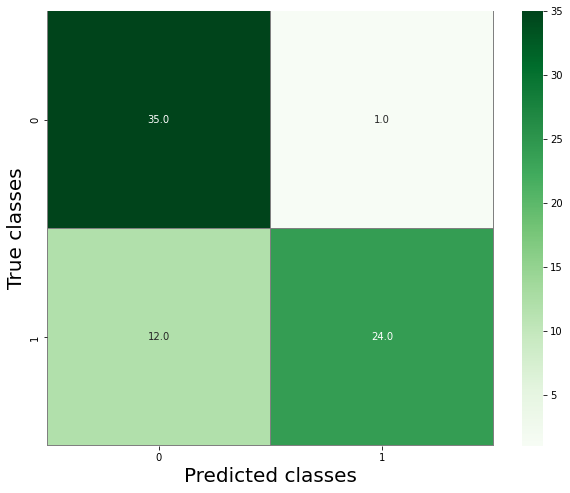

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

# Reverse the true and the predicted labels into the original binary 
# labels (0 and 1) to compute the confusion matrix
y_test_labels = [np.argmax(vect) for vect in y_test]
y_test_pred_labels = [np.argmax(vect) for vect in y_test_pred]

conf_mat = confusion_matrix(y_test_labels, y_test_pred_labels)

plt.figure(figsize = (10,8))
sns.heatmap(conf_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', 
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

In [ ]:
plt.figure(figsize = (15,8))
for i in np.arange(8):
  # take randomly an indice
  ind = random.randint(0, len(X_test))
  img = X_test[ind]
  # reshape the image 
  img_rs = img.reshape(1,227,227,3)
  # predict the label of img
  y_pred = Alexnet_model.predict(img_rs)
  # determine the corresponding category
  predicted_cate = cate[np.argmax(y_pred)]
  plt.subplot(240+1+i)
  plt.imshow(img)
  plt.title('predicted: ' + str(predicted_cate))